# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age`- The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the `target`, the column you are trying to predict.
**test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.Your task is to predict the value of Transported for the passengers in this set.**
**sample_submission.csv - A submission file in the correct format.**
* `PassengerId` - Id for each passenger in the test set.
* `Transported` - The target. For each passenger, predict either True or False.

Metrics: `accuracy`


# Data overview

In [225]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()
cwd = cwd.replace('\\','/')
train = pd.read_csv(cwd + "/spaceship/train.csv")
test = pd.read_csv(cwd + "/spaceship/test.csv")
sub = pd.read_csv(cwd + "/spaceship/sample_submission.csv")

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))
    
df_data = pd.concat([train_d, test])

Train Shape: (8693, 14)
Missing Data: 2324
Duplicates: 0

Test Shape: (4277, 13)
Missing Data: 1117
Duplicates: 0

No duplicates


In [226]:
df_data.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [227]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [228]:
# pandas_profiling.ProfileReport(train_d)

# EDA & FE

In [229]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [230]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [231]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [232]:
df_data.sample(14, axis=1).describe().T.style.bar(
    subset=["mean"], color="#205ff2"
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
Age,12700.000000,28.771969,14.387261,0.000000,19.000000,27.000000,38.000000,79.000000
Spa,12686.000000,308.476904,1130.279641,0.000000,0.000000,0.000000,57.000000,22408.000000
FoodCourt,12681.000000,451.961675,1584.370747,0.000000,0.000000,0.000000,77.000000,29813.000000
VRDeck,12702.000000,306.789482,1180.097223,0.000000,0.000000,0.000000,42.000000,24133.000000
ShoppingMall,12664.000000,174.906033,590.558690,0.000000,0.000000,0.000000,29.000000,23492.000000
RoomService,12707.000000,222.897852,647.596664,0.000000,0.000000,0.000000,49.000000,14327.000000


## Target

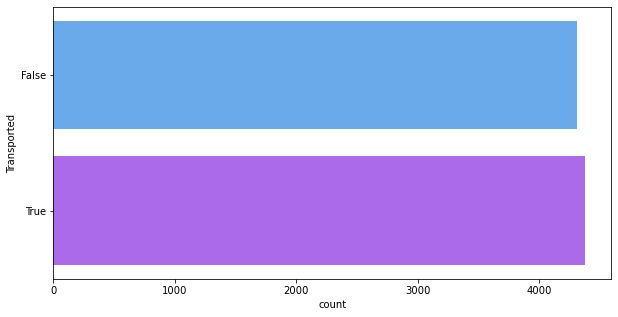

In [233]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['Transported'], palette='cool', orient='h')
plt.show()

## Create features

In [234]:
# df_data['Ageismissing'] = df_data['Age'].isnull()
# df_data['Ageismissing'] = df_data['Ageismissing'].astype(int)
df_data['Age'].fillna(df_data['Age'].mean(), inplace=True)

df_data['RoomService'].fillna(0, inplace=True)
# df_data['PaidRoomService'] = df_data['RoomService'] > 0
# df_data['PaidRoomService'] = df_data['PaidRoomService'].astype(int)


df_data['FoodCourt'].fillna(0, inplace=True)
# df_data['PaidFoodCourt'] = df_data['FoodCourt'] > 0
# df_data['PaidFoodCourt'] = df_data['PaidFoodCourt'].astype(int)

df_data['ShoppingMall'].fillna(0, inplace=True)
# df_data['PaidShoppingMall'] = df_data['ShoppingMall'] > 0
# df_data['PaidShoppingMall'] = df_data['PaidShoppingMall'].astype(int)

df_data['Spa'].fillna(0, inplace=True)
# df_data['PaidSpa'] = df_data['Spa'] > 0
# df_data['PaidSpa'] = df_data['PaidSpa'].astype(int)


df_data['VRDeck'].fillna(0, inplace=True)
# df_data['PaidVRDeck'] = df_data['VRDeck'] > 0
# df_data['PaidVRDeck'] = df_data['PaidVRDeck'].astype(int)

In [235]:
df_data.sample(14, axis=1).describe().T.style.bar(
    subset=["mean"], color="#205ff2"
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
Spa,12970.000000,301.722282,1118.746785,0.000000,0.000000,0.000000,50.000000,22408.000000
Age,12970.000000,28.771969,14.236710,0.000000,20.000000,27.000000,37.000000,79.000000
RoomService,12970.000000,218.378026,641.766201,0.000000,0.000000,0.000000,42.750000,14327.000000
FoodCourt,12970.000000,441.890979,1568.038076,0.000000,0.000000,0.000000,62.750000,29813.000000
ShoppingMall,12970.000000,170.779491,584.153630,0.000000,0.000000,0.000000,23.000000,23492.000000
VRDeck,12970.000000,300.450270,1168.655639,0.000000,0.000000,0.000000,36.000000,24133.000000


In [236]:
df_data['TotalSpend'] = df_data['RoomService'] + df_data['FoodCourt'] + df_data['ShoppingMall'] + df_data['Spa'] + df_data['VRDeck']
df_data['PctRoomService'] = df_data['RoomService']/df_data['TotalSpend']
df_data['PctFoodCourt'] = df_data['FoodCourt']/df_data['TotalSpend']
df_data['PctShoppingMall'] = df_data['ShoppingMall']/df_data['TotalSpend']
df_data['PctSpa'] = df_data['Spa']/df_data['TotalSpend']
df_data['PctVRDeck'] = df_data['VRDeck']/df_data['TotalSpend']
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
df_data[fill_cols] = df_data[fill_cols].fillna(0)


# cabin
df_data.loc[df_data['Cabin'].isnull(), 'Cabin'] = 'None/None/None'
df_data[['deck', 'num','side']] = df_data['Cabin'].str.split('/', expand=True)
df_data['deck']=df_data['deck'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'None':8})
df_data['side']=df_data['side'].replace({'S':0, 'P':1,'None':2})
# HomePlanet
df_data['HomePlanet'].fillna('None', inplace=True)
df_data['HomePlanet'] = df_data['HomePlanet'].map({'Earth': 0, 'Europa': 1,'Mars': 2, 'None': 3})
# Destination
df_data['Destination'].fillna('None', inplace=True)
df_data['Destination'] = df_data['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,'TRAPPIST-1e': 2, 'None': 3})

df_data['group']=df_data['PassengerId'].apply(lambda x: x.split('_')[0])

# PassengerId
df_data.drop('PassengerId', axis=1, inplace=True)


# CryoSleep & VIP
df_data['CryoSleep'] = df_data['CryoSleep'].fillna(False)
df_data['VIP'] = df_data['VIP'].fillna(False)

#bool_type = ['VIP', 'CryoSleep']
bool_type = ['CryoSleep']
df_data[bool_type] = df_data[bool_type].astype(int)
# df_data['PaidVRDeck'] = df_data['PaidVRDeck'].astype(int)

df_data['deck'] = df_data['Cabin'].apply(lambda x: x.split('/')[0])
df_data['num'] = df_data['Cabin'].apply(lambda x: x.split('/')[1])
# df_data['side'] = df_data['Cabin'].apply(lambda x: x.split('/')[2])

df_data.drop('Cabin', axis=1, inplace=True)

df_data['Adult']=True
df_data.loc[df_data['Age']<18, 'Adult']=False
df_data['Name']=df_data['Name'].fillna(method='ffill')
df_data['Under15'] = df_data['Age'].apply(lambda x: 1 if x < 15 else 0)


temp=pd.DataFrame(df_data.groupby(['group'])['Name'])
d={}
for i in range(len(temp)):#len(temp)
    past_last_names=[]
    names=list(temp[1][i])
    rltvs=1
    for j in range(len(list(temp[1][i]))):#len(list(temp[1][i]))
        if(names[j].split(' ')[1] in past_last_names):
            rltvs+=1
        past_last_names.append(names[j].split(' ')[1])

    d[f"{temp[0][i]}"]=rltvs

df_data['has_relatives']=df_data['group'].map(d)

# # Name
df_data.drop('Name', axis=1, inplace=True)



# # # Mean, median, maximum, minimum congestion per roadway / time
# keys = ['roadway','hour', 'minute']
# df = df_data.groupby(by=keys).mean().reset_index().set_index(keys)
# df['mean congestion'] = df['congestion']
# df_data = df_data.merge(df['mean congestion'], how='left', left_on=keys, right_on=keys)

# df = df_data.groupby(by=keys).median().reset_index().set_index(keys)
# df['median congestion'] = df['congestion']
# df_data = df_data.merge(df['median congestion'], how='left', left_on=keys, right_on=keys)

# df = df_data.groupby(by=keys).min().reset_index().set_index(keys)
# df['min congestion'] = df['congestion']
# df_data = df_data.merge(df['min congestion'], how='left', left_on=keys, right_on=keys)

# df = df_data.groupby(by=keys).max().reset_index().set_index(keys)
# df['max congestion'] = df['congestion']
# df_data = df_data.merge(df['max congestion'], how='left', left_on=keys, right_on=keys)




from sklearn.preprocessing import LabelEncoder
qualitative = [col for col in df_data if df_data[col].dtype == 'object']
for feature in qualitative:
    if feature != "Transported":
        df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!memory reduction    
df_data = reduce_mem_usage(df_data)

df_train = df_data[df_data.Transported.isnull() == False]
df_test = df_data[df_data.Transported.isnull() == True]

df_train['Transported'] = df_train['Transported'].astype(int)
df_test = df_test.drop(['Transported'],axis=1)

X = df_train.drop('Transported', axis=1)
y = df_train['Transported']

XX = X.copy()
yy = y.copy()
print(df_train.shape, df_test.shape)


df_data.drop('Destination', axis=1, inplace=True)
df_data.drop('VIP', axis=1, inplace=True)
# df_data.drop('Adult', axis=1, inplace=True)

Mem. usage decreased to  0.95 Mb (54.7% reduction)
(8693, 24) (4277, 23)


In [237]:
df_data.head(5)

,HomePlanet,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpend,...,PctShoppingMall,PctSpa,PctVRDeck,deck,num,side,group,Adult,Under15,has_relatives
0,1,0,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0.000000,0.000000,0.000000,1,0,1,0,True,0,1
1,0,0,24.0,109.0,9.0,25.0,549.0,44.0,True,736.0,...,0.033967,0.745924,0.059783,5,0,0,1,True,0,1
2,1,0,58.0,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,...,0.000000,0.646730,0.004719,0,0,0,2,True,0,2
3,1,0,33.0,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,...,0.071677,0.643161,0.037287,0,0,0,2,True,0,2
4,0,0,16.0,303.0,70.0,151.0,565.0,2.0,True,1091.0,...,0.138405,0.517874,0.001833,5,1,0,3,False,0,1


In [238]:
df_test.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PctShoppingMall,PctSpa,PctVRDeck,deck,num,side,group,Adult,Under15,has_relatives
0,0,1,2,27.0,False,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,6,1117,0,12,True,0,1
1,0,0,2,19.0,False,0.0,9.0,0.0,2823.0,0.0,...,0.000000,0.996822,0.000000,5,1228,0,17,True,0,1
2,1,1,0,31.0,False,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,2,0,0,18,True,0,1
3,1,0,2,38.0,False,0.0,6652.0,0.0,181.0,585.0,...,0.000000,0.024400,0.078862,2,1,0,20,True,0,1
4,0,0,2,20.0,False,10.0,0.0,635.0,0.0,0.0,...,0.984496,0.000000,0.000000,5,1339,0,22,True,0,1


## Mutual Information

In [239]:
# # see best parameters by mutial information
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBRegressor

# def make_mi_scores(X, y):
#     X = X.copy()
#     for colname in X.select_dtypes(["object"]):
#         X[colname], _ = X[colname].factorize()
#     # All discrete features should now have integer dtypes
#     #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     mi_scores = mutual_info_regression(X, y, random_state=0)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# y = df_data[df_data['Transported'].isnull() == False]['Transported']
# x = df_data[df_data['Transported'].isnull() == False].drop('Transported', axis=1)
# mi_scores = make_mi_scores(x, y)
# mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'Feature'})

In [240]:
# fig = px.bar(mi_scores, x='MI Scores', y='Feature', color="MI Scores",
#              color_continuous_scale='darkmint')
# fig.update_layout(height = 750, title_text="Mutual Information Scores",
#                   title_font=dict(size=29, family="Lato, sans-serif"), xaxis={'categoryorder':'category ascending'}, margin=dict(t=80))

In [241]:
# plt.figure(figsize=(17,17))
# corr=df_data.corr(method='spearman')
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(30, 20))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# # Draw the heatmap with the mask and correct aspect ratio
# g=sns.heatmap(corr, mask=mask,annot=True,cmap="YlGnBu", vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## PCA

In [242]:
# from sklearn.preprocessing import StandardScaler 
# train_standard = StandardScaler().fit_transform(train)

# train_standard = pd.DataFrame(train_standard, index=train.index, columns=train.columns)
# train_standard.head(2)

In [243]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(train_standard)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
# principalDf.head(2)

In [244]:
# pca.explained_variance_ratio_

In [245]:
# print(np.cumsum((pca.explained_variance_ratio_)))

In [246]:
# train = pd.concat([train, principalDf], axis = 1)
# train.head(2)

In [247]:
# # test
# test_standard = StandardScaler().fit_transform(test)
# test_standard = pd.DataFrame(test_standard, index=test.index, columns=test.columns)


# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(test_standard)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
# test = pd.concat([test, principalDf], axis = 1)

In [248]:
# print(np.cumsum((pca.explained_variance_ratio_)))

In [249]:
# print(train.shape, test.shape)

# Modeling

## Choosing the best model

In [250]:
# from pycaret.classification import *


# s = setup(data = df_train,
#           target = 'Transported',
#           train_size = 0.8,
#           fold_strategy = 'stratifiedkfold',
#           fold = 5,
#           fold_shuffle = True)

In [251]:
# best_model = compare_models()

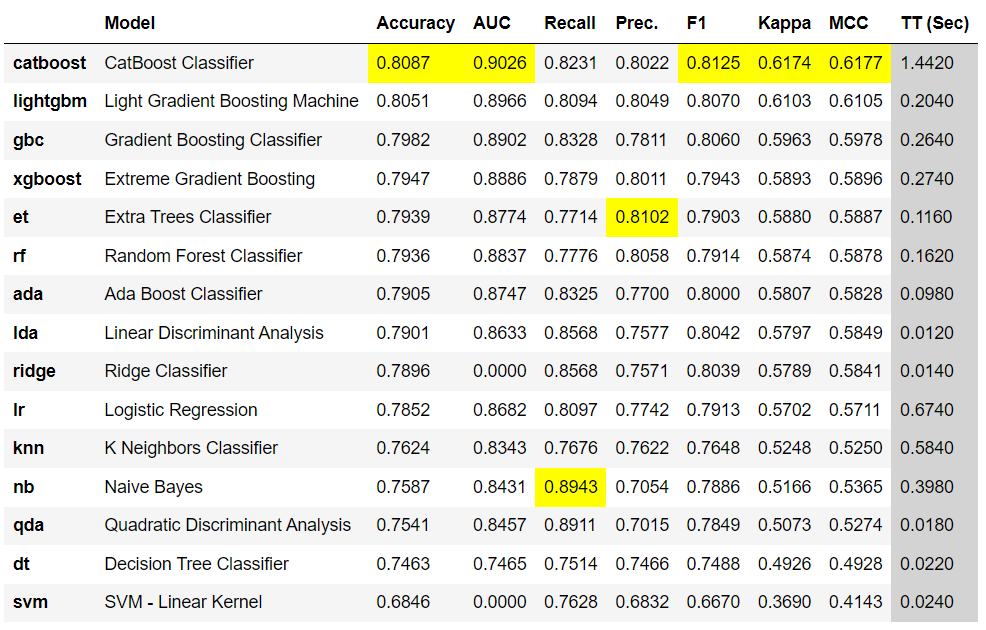

## Stacking

In [252]:
from sklearn.model_selection import KFold
import xgboost as xgb
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [290]:
# Some useful parameters which will come in handy later on
ntrain = X.shape[0]
ntest = df_test.shape[0]
SEED = 0 # for reproducibility
N_SPLITS = 5 # set folds for out-of-fold prediction

kf = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0):
        #params['random_state'] = seed
        self.clf = clf()
#         self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [255]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [256]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED)
# cat = SklearnHelper(clf=CatBoostClassifier, seed=SEED)
lgb_m = SklearnHelper(clf=lgb.LGBMClassifier, seed=SEED)
svc = SklearnHelper(clf=SVC, seed=SEED)

Creating `NumPy arrays` out of our train and test sets

In [257]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = y

x_train = X.values # Creates an array of the train data
x_test = df_test.values # Creats an array of the test data

Output of the `First level` Predictions

In [258]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
# cat_oof_train, cat_oof_test = get_oof(cat,x_train, y_train, x_test) # Catboost Boost
lgb_oof_train, lgb_oof_test = get_oof(lgb_m,x_train, y_train, x_test) # Catboost Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [259]:
# svc.feature_importances(x_train,y_train)

`Feature importances` generated from the different classifiers

In [260]:
rf_features = [0.03338559, 0.0447491,  0.02007685, 0.07561468, 0.00123754, 0.03764667,
 0.03845932, 0.03351281, 0.04641349, 0.04121607, 0.10175464, 0.05198335,
 0.0495477,  0.04090464, 0.04985006, 0.05155477, 0.0405416,  0.09430267,
 0.01806214, 0.09283245, 0.00524092, 0.00438005, 0.02673288]

et_features = [0.0369985,  0.11495084, 0.02878235, 0.07409384, 0.00259813, 0.02588925,
 0.02260888, 0.0230042,  0.02679054, 0.02576945, 0.03307644, 0.07317135,
 0.04822516, 0.03354856, 0.07641569, 0.06450407, 0.04853988, 0.08131838,
 0.02455765, 0.08251495, 0.00945706, 0.00799815, 0.03518667]

ada_features = [0.02, 0.02, 0.02, 0.06, 0.,   0.06, 0.08, 0.06, 0.06, 0.08, 0.06, 0.,   0.1,  0.06,
 0.02, 0.02, 0.08, 0.1,  0.02, 0.06, 0.,   0.,   0.02,]

# cat_features = [6.81956307, 6.52050652,  2.19926256,  4.30636689,  0.04263748,  2.31318177,
#   2.27045387,  2.50473739,  3.19125602,  3.01212115, 16.33581425,  2.70563523,
#   6.30577215,  3.63658059, 4.01298619,  3.26763442, 12.4676744,   6.68277598,
#   4.68721691,  4.93840131,  0.39043948,  0.35416354,  1.03481881]

lgb_features = [95,  45,  61, 248,   0, 130, 109, 105, 161, 134, 273,  81, 144, 104, 140, 127, 236, 347,
 113, 278,   3,   0,  66]


In [261]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra tree  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
#     'Catboost  feature importances':cat_features,
    'LGB feature importances': lgb_features
    })

Interactive feature importances via Plotly scatterplots

In [262]:
import plotly.offline as py

# Random forest
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


# Extra tree
trace = go.Scatter(
    y = feature_dataframe['Extra tree  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra tree  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra tree  feature importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


# AdaBoost
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost feature importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# # CatBoost
# trace = go.Scatter(
#     y = feature_dataframe['Catboost  feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 25,
# #       size= feature_dataframe['AdaBoost feature importances'].values,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Catboost  feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = feature_dataframe['features'].values
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'Catboost  feature importances',
#     hovermode= 'closest',
# #     xaxis= dict(
# #         title= 'Pop',
# #         ticklen= 5,
# #         zeroline= False,
# #         gridwidth= 2,
# #     ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

# LGB 
trace = go.Scatter(
    y = feature_dataframe['LGB feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['LGB feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'LGB feature importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')




Now let us calculate the `mean` of all the feature importances and store it as a new column in the feature importance dataframe.

In [263]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(5)

,features,Random Forest feature importances,Extra tree feature importances,AdaBoost feature importances,LGB feature importances,mean
0,HomePlanet,0.033386,0.036998,0.02,95,23.772596
1,CryoSleep,0.044749,0.114951,0.02,45,11.294925
2,Destination,0.020077,0.028782,0.02,61,15.267215
3,Age,0.075615,0.074094,0.06,248,62.052427
4,VIP,0.001238,0.002598,0.00,0,0.000959
5,RoomService,0.037647,0.025889,0.06,130,32.530884
6,FoodCourt,0.038459,0.022609,0.08,109,27.285267
7,ShoppingMall,0.033513,0.023004,0.06,105,26.279129
8,Spa,0.046413,0.026791,0.06,161,40.283301
9,VRDeck,0.041216,0.025769,0.08,134,33.536746


In [264]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

`First-level` `output` as new features

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [265]:
base_predictions_train = pd.DataFrame( {
    'RandomForest': rf_oof_train.ravel(),
    'Extra tree': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
#     'CatBoost': cat_oof_train.ravel(),
    'LGB': lgb_oof_train.ravel(),
    })
base_predictions_train.head(2)

,RandomForest,Extra tree,AdaBoost,LGB
0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0


In [266]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [267]:
x_train_new = np.concatenate(( rf_oof_train, et_oof_train, cat_oof_train,  svc_oof_train), axis=1)
x_test_new = np.concatenate(( rf_oof_test, et_oof_test, cat_oof_test,  svc_oof_test), axis=1)

`Second level` learning model

In [ ]:
# cat_final = CatBoostClassifier()
# cat_final.fit(x_train, y_train, plot=True)

# predictions = cat_final.predict(x_test)

In [ ]:
# def save_submission(y_pred):  
#     #classes = label.inverse_transform(y_pred)
#     sub["Transported"] = y_pred
#     #assert len(classes) == sub.shape[0]
#     assert 2 == sub.shape[1]   
#     sub.to_csv("E:/downloads/sample_submission.csv", index=False)
#     return sub
#predictions = predictions.astype('bool')
# save_submission(predictions).head(3)

## CV

In [278]:
x_train_new = pd.DataFrame(x_train_new, columns = ['y_0', 'y_1', 'y_2', 'y_3'])
X_final = pd.concat([XX, x_train_new], axis=1)

x_test_new = pd.DataFrame(x_test_new, columns = ['y_0', 'y_1', 'y_2', 'y_3'])
test_final = pd.concat([df_test, x_test_new], axis=1)

In [289]:
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
import statistics
import datetime

# scores_on_split = []
# for N_SPLITS in range(105,121,5):

N_SPLITS = 100 # 200 is the best score on LB
RANDOM_STATE = 42 


scores = []
y_probs = []
y_probs_final = []

print('Total splits: ', N_SPLITS)
folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X_final, yy)):  

    print("fold : ", fold + 1, end = ' ')

    X_train = X_final.iloc[train_id]
    y_train = yy.iloc[train_id]
    X_valid = X_final.iloc[test_id]
    y_valid = yy.iloc[test_id]

#     # def
#     model_def = CatBoostClassifier(verbose=False)
#     model_def.fit(X_train, y_train)
#     valid_pred_def = model.predict(X_valid)
#     valid_score_def = accuracy_score(y_valid, valid_pred_def)
    
    # ensamble
#     model = BaggingClassifier(base_estimator=CatBoostClassifier(verbose=False), random_state=42)

    model = CatBoostClassifier(verbose=False)
    start = datetime.datetime.now()
    model.fit(X_train, y_train)
    end = datetime.datetime.now()

    # validation
    valid_pred = model.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred)
    print( "Validation score: ", valid_score, 'Time:', end - start)
    scores.append(valid_score)

    # test
    #y_pred = model.predict(df_test)
    y_probs.append(model.predict_proba(test_final))
    print("")
#     scores_on_split.append(statistics.mean(scores))


# scores_on_split

Total splits:  100
fold :  1 Validation score:  0.8275862068965517 Time: 0:00:03.952947

fold :  2 Validation score:  0.8045977011494253 Time: 0:00:03.827999

fold :  3 Validation score:  0.9080459770114943 Time: 0:00:04.028000

fold :  4 Validation score:  0.8505747126436781 Time: 0:00:04.650003

fold :  5 Validation score:  0.7816091954022989 Time: 0:00:04.737004

fold :  6 Validation score:  0.8275862068965517 Time: 0:00:04.622995

fold :  7 Validation score:  0.8160919540229885 Time: 0:00:04.254001

fold :  8 Validation score:  0.7471264367816092 Time: 0:00:05.032997

fold :  9 Validation score:  0.8275862068965517 Time: 0:00:04.030002

fold :  10 Validation score:  0.7586206896551724 Time: 0:00:03.916997

fold :  11 Validation score:  0.8275862068965517 Time: 0:00:03.941000

fold :  12 Validation score:  0.8390804597701149 Time: 0:00:03.841000

fold :  13 Validation score:  0.8045977011494253 Time: 0:00:03.893000

fold :  14 Validation score:  0.7931034482758621 Time: 0:00:04.0140

In [291]:
# 0.8153986928104575 - 500

# 0.8167548783747661 - 100
# 0.8182521395655036 - 140
# 0.8187900786448881 - 150
# 0.8169900557846228 - 155
# 0.8145664983164983 - 160
# 0.8175317124735729 - 200
import statistics
statistics.mean(scores)

0.8159315690991713

In [ ]:
# i = np.arange(105,121,5)
# plt.plot(i, scores_on_split)

# Submission

In [ ]:
sub.head(2)

In [ ]:
# # y_pred = predict_model(lr, data=test)
# # y_pred = y_pred['Label']


# preds = []
# for i in y_pred:
#     if i == 0:
#         preds.append(False)
#     else:
#         preds.append(True)

# sub['Transported'] = preds

# sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
# sub.head()

In [292]:
y_probs_final = sum(y_probs) / len(y_probs)
y_probs_final

preds = []
for i in y_probs_final:
    if i[0] > i[1]:
        preds.append(False)
    else:
        preds.append(True)
        
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["Transported"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub
save_submission(preds).head(3)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
